<a href="https://colab.research.google.com/github/BubuDavid/Fundamentos-de-Procesamiento-Digital-de-Imagenes/blob/main/tareas/tarea10/Tarea10_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 10
Puede ver el código original en el siguiente link: https://colab.research.google.com/drive/1yelrvMeFiNKHOFus24EYAXktDz3QBYXZ?usp=sharing

# Funciones auxiliares

En la siguiente celda, se podrán encontrar funciones que son útiles al momento de estar trabajando en esta materia, cada función tiene su propia descripción y uso. Ya tengo un documento plantilla para copiar y pegar estas funciones por lo que puede llegar el caso de que no usemos alguna de las funcioens que estén aquí.

In [1]:
# Este script tiene algunas funciones que son útiles tanto en tareas como en apuntes de la clase
# Importando librerías
import cv2 # Para manejar imágenes
import matplotlib.pyplot as plt # Para visualizar las imágenes (Se puede hacer de otra manera con una librería de google pero meh, este está bueno)
import numpy as np # Para operar matrices de manera sencilla
from scipy.ndimage import correlate, convolve


##### Operaciones iniciales con imágenes (Leer, mostrar, mostrar histogramas, etc.) #####
# Desplegar histogramas
# Leer imagen en escala de grises
def read_img(img_name, **kwarg):
	"""Lee imágenes con ayuda de opencv y la muestra

	Args:
		img_name (str): Nombre del path donde se encuentra la imagen

	Returns:
		np.array: Retorna la imagen que se leyó después de mostrarla
	"""
	img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
	show_img(img, is_gray = True, info = True, **kwarg)
	return img

# Mostrar imágenes
def show_img(img, size = (7, 7), is_gray = True, info = False, is_double = False):
    """Muestra una imagen con tamaño específico.

    Args:
        img (np.array): Imagen que se desea mostrar
        size (tuple, optional): Tamaño relativo de la imagen. Recomendado (7, 7).
        is_gray (bool, optional): Si la imagen es en blanco y negro activar. Recomendado True.
        info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
    """
    vmin = 0
    vmax = 1 if is_double else 255

    fig, axs = plt.subplots(figsize=size)
    if is_gray:
        axs.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs.imshow(img)
    axs.axis("off")

    if info:
        print(f"Imagen de dimensiones: {img.shape}, con un total de {img.size} pixeles")

# Mostrar varias imágenes
def show_imgs_row(imgs, size = (7,7), is_gray = True, info = False, titles = None, is_double = False, max_pixels = 255):
    """Muestra imágenes en una sola fila (se recomiendan menos de 5 imágenes para mejor visibilidad)

    Args:
        imgs (List[np.array]): Lista de imágenes a desplegar
        size (tuple, optional): Tamaño relativo de cada imagen a desplegar. Recomendado (7,7).
        is_gray (bool, optional): Si es o no blanco y negro. Recomendado True.
        info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
        titles (_type_, optional): Lista de títulos para la imagen. Recomendado None.
    """
    schema = (1, len(imgs))
    options = {}
    if is_gray:
        options["cmap"] = "gray"
        options["vmin"] = 0

    fig, axs = plt.subplots(*schema, figsize=size)

    for index in range(len(imgs)):
        vmax = 1 if is_double and is_double[index] else max_pixels
        axs[index].imshow(imgs[index], vmax = vmax, **options)
        axs[index].axis("off")
        if titles:
            axs[index].set_title(titles[index])

def show_histograms(imgs, bin_value = 20, colors = [None, "g"], titles = ["Normal", "No normal"], normalized = True, edgecolor = "black", cumulative = False, size = (15, 5), **kwargs):
	"""Muestra y regresa histogramas de las imágenes que le pases.

	Args:
		imgs (List[np.array]): Lista de imágenes a calcular sus histograms
		bin_value (int, optional): Rango de los bins en nuestros plots. Recomendado 20.
		colors (list, optional): Lista de colores para los histogramas. Recomendado [None, "g"].
		titles (list, optional): Lista de títulos para los histogramas. Recomendado ["Normal", "No normal"].
		normalized (bool, optional): Dicta si los histogramas están normalizados o no. Recomendado True.
		edgecolor (str, optional): El color del borde de cada bin, también se puede dejar en None si no quieres borde. Recomendado "black".
		cumulative (bool, optional): Esto indica si los histogramas son acumultivos o no. Recomendado False.
		size (tuple, optional): Tamaño de las gráficas. Recomendado (15, 5).

	Returns:
		hist: Lista con los histogramas calculados.
		bins: Lista con los bins calculados aunque usualmente son iguales todos.
	"""
	if type(imgs) != list:
		imgs = [imgs]
	if type(titles) != list:
		titles = [titles]
	
	flattens = np.array(list(map(lambda img: img.ravel(), imgs)))
	bins = np.array([np.linspace(0, 255, bin_value) for i in range(len(imgs))])
	hists = []
	fig, ax = plt.subplots(1, len(imgs), figsize = size)
	
	if len(imgs) == 1:
		img, b = imgs[0], bins[0]
		
		hist, b = np.histogram(img, bins = b)
		if normalized:
			hist = hist / img.size
		if cumulative:
			hist = np.cumsum(hist)
		ax.hist(b[:-1], b, weights = hist, color = colors[0], edgecolor = edgecolor, **kwargs)
		ax.set_title(titles[0])
		return hist, b
	else:
		for index in range(len(flattens)):
			img, b = imgs[index], bins[index]
			hist, b = np.histogram(img, bins = b)
			if normalized:
				hist = hist / img.size
			if cumulative:
				hist = np.cumsum(hist)
			
			ax[index].hist(b[:-1], b, weights = hist, color = colors[index], edgecolor = edgecolor, **kwargs)
			ax[index].set_title(titles[index])
			hists.append(hist)
	return hists, bins

###### Transformaciones generales sobre imágenes ######
# Creditos: http://learnwebgl.brown37.net/08_projections/projections_mapping.html
def img_scale(img, minf, maxf):
    a, b = np.min(img), np.max(img)
    scale = (maxf - minf)/(b - a)
    offset = -a*scale + minf
    rescaled = img*scale + offset
    return rescaled

###### Transformaciones de intensidades de imágenes ######

# Binarize images

# Transformación Negativa
def imcomplement(img):
	"""Función para generar el negativo de una imagen en blanco y negro

	Args:
		img (np.array): Imagen a negativizar

	Returns:
		negative_img: Imagen negativa
	"""
	return np.abs(255 - img)

# Genera imagenes binarias
def binarize(img, max_val):
	"""Genera imágenes binarias a partir de un cierto max_val

	Args:
		img (np.array): Imagen a binarizar
		max_val (int): Límite en el cual se considera 1 o 0

	Returns:
		binarized_img: Imagen binaria obtenida
	"""
	return (img >= max_val) * 255

# Credits: https://www.nzfaruqui.com/contrast-stretching-in-image-processing-using-matlab/
def imadjust(img,lim_in = [0, 1], lim_out = [0, 1], gamma=1, plot = False):
	"""Imagen que ajusta a un rango determinado con una gamma correction definida (Hace lo mismo que la función de matlab)

	Args:
		img (np.array): Imagen a transformar
		lim_in (list, optional): Limites de la imagen de input. Defaults to [0, 1].
		lim_out (list, optional): Limites de la imagen de output. Defaults to [0, 1].
		gamma (int, optional): Factor gamma de la función. Defaults to 1.
		plot (bool, optional): Si se desea graficar le función gamma. Defaults to False.

	Returns:
		adjusted_img: Imagen ajustada
	"""
	c, d = lim_in
	a, b = lim_out
	# Normalización para que esto funcione
	img_cp = img.copy()
	if np.max(img_cp) > 1:
		img_cp = img_cp / np.max(img_cp)

	# Básicamente esto es lo que hace imadjust ☝ ver la fuente para mayor información
	adj = (((img_cp - a) / (b - a)) ** gamma) * (d - c) + c
	# Regresando a las dimensiones originales
	adj = np.int64(adj / np.max(adj) * 255)

	# Grafica la función
	if plot:
		x = np.linspace(0, 1, 1000)
		y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
		plt.plot(x,y, c='g')
		plt.title(f'Función adjust con a={a}, b={b}, c={c}, d={d}, gamma={gamma}')
	return adj

def equalizeHist(img):
	"""Función que ecualiza el histograma de una imagen

	Args:
		img (np.array): Imagen a ser ecualizada

	Returns:
		equ_img: Imagen Ecualizada
	"""
	return cv2.equalizeHist(img)

###### fspecials ######
def fspecial_gauss(kernel_shape=(3,3), sigma=0.5):
    m,n = [(ss-1.)/2. for ss in kernel_shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def fspecial_laplacian(alpha = 1/5):
    alpha = max(0,min(alpha,1))
    h1 = alpha/(alpha+1)
    h2 = (1-alpha)/(alpha+1)
    h = np.array([[h1, h2, h1], [h2, -4/(alpha + 1), h2], [h1, h2, h1]])
    return h

def fspecial_average(shape):
	h = np.ones(shape)/np.prod(shape)
	return h

##### NORMALIZE IMAGES #############
def normalize_img(img, norm_factor = 1):
	if (np.max(img) - np.min(img)) != 0:
		return (img - np.min(img)) / (np.max(img) - np.min(img)) * norm_factor
	
	return img / np.max(img)

# Problemas y resolución

## 1. (1 punto) Asegurese de que la función GeneraNotchIdeal funciona correctamente, para lograr esto genere una imagen que tenga solo franjas con (u,v) ciclos, la puede generar con el códgo visto en las primeras clases del semestre o formando una imagen con dos deltas de Kroneker, una en (u,v) y otra en (-u,-v) y antitransforme. Con la imagen generada ahora aplique el filtro Notch diseñado con GeneraNotchIdeal, si al aplicar el fioltro obtiene una imagen de 0’s la función hace bien su trabajo.

In [41]:
# Funciones auxiliares
def genera_LP_ideal(img, d0):
    # Genera una función de pasa bajos ideal en el dominio de la frecuencia con una frecuencia de corte D0.
    m, n = img.shape
    if m % 2 == 0:
        r = np.arange(-m//2, m//2)
    else:
        r = np.arange(-m//2, m//2 + 1)
    if n % 2 == 0:
        c = np.arange(-n//2, n//2)
    else:
        c = np.arange(-n//2, n//2 + 1)
    C, R = np.meshgrid(c, r)

    D = np.sqrt(R**2 + C**2)
    H_LP = (D < d0)*1.0
    H_LP = np.fft.ifftshift(H_LP)
    return H_LP

def genera_HP_ideal(im, d0):
    # Genera un filtro de paso alto ideal en el dominio de la frecuencia con una frecuencia de corte D0.
    h_lp = genera_LP_ideal(im, d0)
    h_hp = 1 - h_lp
    return h_hp

def genera_notch_ideal(im, d0, u0, v0):
    # Genera un filtro de rechazo de banda ideal en el dominio de la frecuencia con dos componentes notch en las frecuencias especificadas por u0 y v0.
    hp = genera_HP_ideal(im, d0)
    hp = np.fft.ifftshift(hp)
    h_notch_ideal_1 = np.roll(np.roll(hp, u0, axis=0), v0, axis=1)
    h_notch_ideal_2 = np.roll(np.roll(hp, -u0, axis=0), -v0, axis=1)
    h_notch_ideal = h_notch_ideal_1 * h_notch_ideal_2
    h_notch_ideal = np.fft.ifftshift(h_notch_ideal)
    return h_notch_ideal


def aplica_filtro_frec(img, h):
    # Obteniendo las dimensiones de la imagen y el filtro
    mi, ni = img.shape
    mh, nh = h.shape

    # Verificando si el tamaño de la imagen y el filtro son iguales
    if mi == mh and ni == nh:
        # Aplicando la transformada de Fourier bidimensional a la imagen
        f_img = np.fft.fft2(img)

        # Aplicando el filtro en el dominio de la frecuencia
        f_img_f = f_img * h

        # Aplicando la transformada de Fourier inversa bidimensional
        img_f = np.fft.ifft2(f_img_f)

        # Devolviendo la imagen filtrada
        return img_f.real
    else:
        # Lanzando un error si el tamaño de la imagen y el filtro son diferentes
        raise ValueError('El filtro no tiene la dimensión apropiada para la imagen')


In [3]:
from scipy.fft import fft2, fftshift, ifftshift, ifft2

In [8]:
# Creando imagen básica
N = 128  # renglones
M = 256  # columnas
u = 10   # Frecuencia en renglones
v = 10   # Frecuencia en columnas
r = np.arange(N)
c = np.arange(M)
C, R = np.meshgrid(c, r)
img = np.cos(2*np.pi*(R/N)*u + 2*np.pi*(C/M)*v)

im_shape = img.shape
d0 = 5
notch_filter = genera_notch_ideal(img, d0, u, v)

# Aplicar el filtro notch ideal a la imagen en el dominio de la frecuencia
filtered_img_fft = np.fft.fft2(img) * notch_filter
filtered_img = np.real(np.fft.ifft2(filtered_img_fft))


# Verificar si la imagen filtrada es cero
if np.allclose(filtered_img, np.zeros((N, M))):
    print("La función genera_notch_ideal funciona correctamente.")
else:
    print("La función genera_notch_ideal no funciona correctamente.")

La función genera_notch_ideal funciona correctamente.


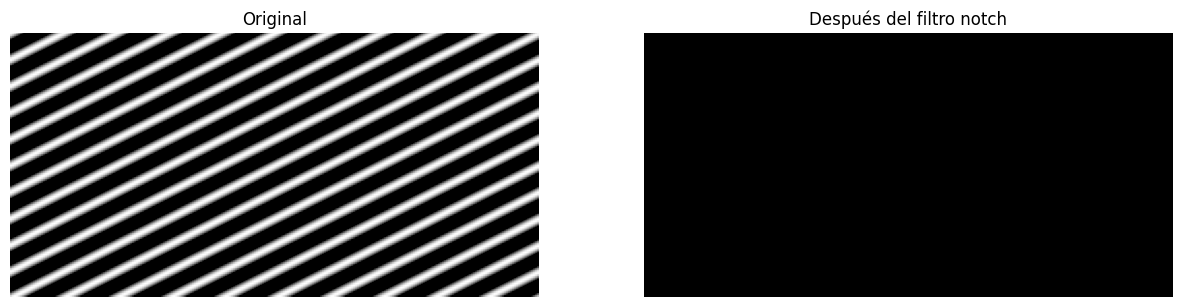

In [13]:
# Solo para visualizar
show_imgs_row(
    [img, filtered_img],
    titles = [
        'Original',
        'Después del filtro notch'
    ],
    is_double = [True, True],
    size = (15, 15)
)

## 2. (1 punto) Programe la función GeneraLPButterworth, que dada una imagen, la frecuencia de corte D0 y el orden del filtro n.; genere un filtro pasabajos de Butterworth.

In [32]:
def genera_LP_butterworth(img, d0, n):
    # Genera un filtro pasabajos de Butterworth en el dominio de la frecuencia con frecuencia de corte d0 y orden n
    M, N = img.shape
    if M % 2 == 0:
        r = np.arange(-M/2, M/2)
    else:
        r = np.arange(-(M-1)/2, (M+1)/2)
    if N % 2 == 0:
        c = np.arange(-N/2, N/2)
    else:
        c = np.arange(-(N-1)/2, (N+1)/2)
    C, R = np.meshgrid(c, r)

    D = np.sqrt(R**2 + C**2)
    H_LP_B = 1 / (1 + (D / d0)**(2*n))  # Fórmula para un filtro pasabajos de Butterworth
    H_LP_B = np.fft.ifftshift(H_LP_B)
    return H_LP_B

## 3. (1 punto) Programe la función GeneraHPButterworth, que dada una imagen, la frecuencia de corte D0 y el orden del filtro n; genere un filtro pasaaltos de Butterworth.

In [33]:
def genera_HP_butterworth(img, d0, n):
    # Genera un filtro pasaaltos de Butterworth en el dominio de la frecuencia con frecuencia de corte d0 y orden n
    H_LP_B = genera_LP_butterworth(img, d0, n)
    H_HP_B = 1 - H_LP_B  # Fórmula para un filtro pasaaltos de Butterworth
    return H_HP_B

## 4. (1 punto) Programe la función GeneraHPGaussiano, que dada una imagen, la frecuencia de corte D0 y el orden del filtro n; genere un filtro pasaaltos de Butterworth

In [34]:
def genera_LP_gaussiano(img, d0):
    # Genera un filtro pasabajos gaussiano en el dominio de la frecuencia con frecuencia de corte d0
    M, N = img.shape
    if M % 2 == 0:
        r = np.arange(-M/2, M/2)
    else:
        r = np.arange(-(M-1)/2, (M+1)/2)
    if N % 2 == 0:
        c = np.arange(-N/2, N/2)
    else:
        c = np.arange(-(N-1)/2, (N+1)/2)
    C, R = np.meshgrid(c, r)

    D2 = R**2 + C**2
    H_LP_G = np.exp(-D2 / (2 * d0**2))  # Fórmula para un filtro pasabajos gaussiano
    H_LP_G = np.fft.ifftshift(H_LP_G)
    return H_LP_G


def genera_HP_gaussiano(img, d0):
    # Genera un filtro pasaaltos gaussiano en el dominio de la frecuencia con frecuencia de corte d0
    H_LP_G = genera_LP_gaussiano(img, d0)
    H_HP_G = 1 - H_LP_G  # Fórmula para un filtro pasaaltos gaussiano
    return H_HP_G

## 5. (1 puntos) A la imagen mama.tiff aplique los filtros pasa bajos de los 3 tipos con frecuencia de corte D0=50, en el caso del filtro de Butterworth elija el orden n=3.

In [35]:
from scipy import fftpack

Imagen de dimensiones: (1164, 984), con un total de 1145376 pixeles


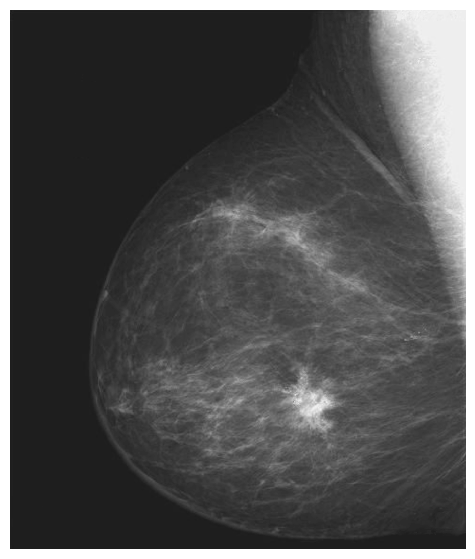

In [36]:
img = read_img('mama.tif')
# Calcular la transformada de Fourier 2D de la imagen
F = fftpack.fft2(img)

In [54]:
# Definiendo la frecuencia de corte y los órdenes de los filtros
d0 = 50
n0 = 3

# Creando los filtros pasa-bajas
H_LP = genera_LP_ideal(img, d0)
H_LP_G = genera_LP_gaussiano(img, d0)
H_LP_B = genera_LP_butterworth(img, d0, n0)

# Aplicando los filtros pasa-bajas
img_LP = aplica_filtro_frec(img, H_LP)
img_LP_G = aplica_filtro_frec(img, H_LP_G)
img_LP_B = aplica_filtro_frec(img, H_LP_B)

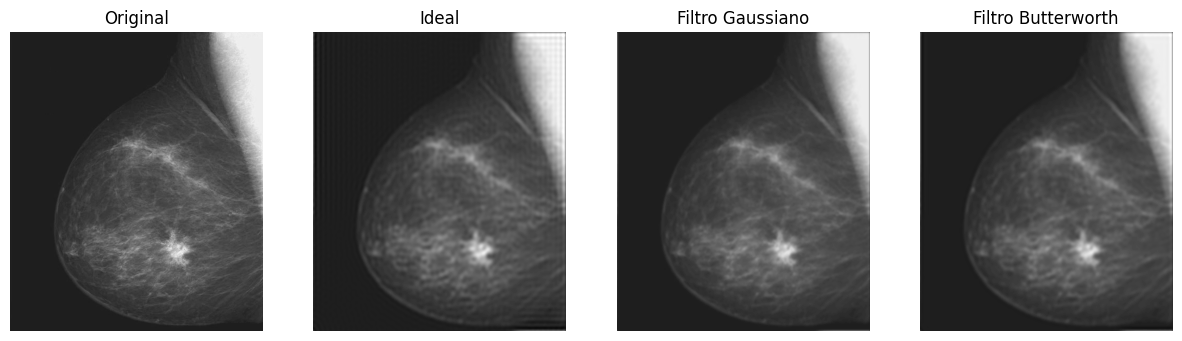

In [55]:
# Mostrando los resultados
show_imgs_row(
    [np.abs(img), np.abs(img_LP), np.abs(img_LP_G), np.abs(img_LP_B)],
    titles = [
        "Original",
        "Ideal",
        "Filtro Gaussiano",
        "Filtro Butterworth"
    ],
    is_double = [False, False, False, False],
    size = (15,15)
)

## 6. (1 puntos) A la imagen mama.tiff aplique los filtros pasa altos de los 3 tipos con frecuencia de corte D0=50, en el caso del filtro de Butterworth elija el orden n=5.

In [56]:
# Definiendo la frecuencia de corte
D0 = 50

# Definiendo el orden para el filtro de Butterworth
n0 = 5

# Creando los filtros pasa altos
H_HP = 1 - genera_LP_ideal(img, D0)
H_HP_G = 1 - genera_LP_gaussiano(img, D0)
H_HP_B = genera_HP_butterworth(img, D0, n0)

# Aplicando los filtros pasa altos
img_HP = aplica_filtro_frec(img, H_HP)
img_HP_G = aplica_filtro_frec(img, H_HP_G)
img_HP_B = aplica_filtro_frec(img, H_HP_B)

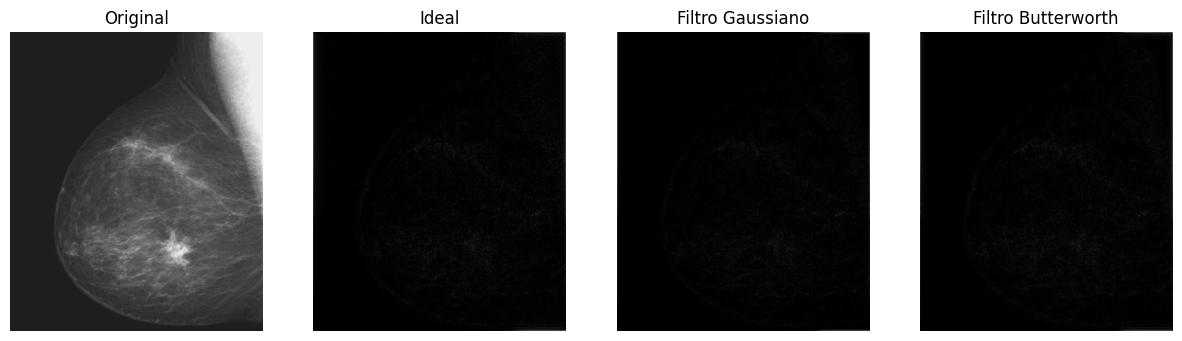

In [57]:
# Mostrando los resultados
show_imgs_row(
    [np.abs(img), np.abs(img_HP), np.abs(img_HP_G), np.abs(img_HP_B)],
    titles = [
        "Original",
        "Ideal",
        "Filtro Gaussiano",
        "Filtro Butterworth"
    ],
    is_double = [False, False, False, False],
    size = (15,15)
)